# Gaussian Processes Regression

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import gaussian_process as GP
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
np.random.seed(6)

In [2]:
# First define input test points at which to evaluate the sampled functions
X_test = np.arange(0, 15, 0.005)[:, np.newaxis] # in general these can be > 1d, hence the extra axis.

In [3]:
# Set the parameters for each kernel.
sigma_f_sq = 1 # Linear
l = 1  # Squared Exponential
alpha = 1 # RationalQuadratic
f = 1/(2*np.pi) # Periodic

In [4]:
# Instantiate GPs using each of these kernels.
gps = {'Linear': GP.GPR(kernel=GP.Linear(sigma_f_sq)), 
       'SquaredExponential': GP.GPR(kernel=GP.SquaredExponential(l)),
       'RationalQuadratic': GP.GPR(kernel=GP.RationalQuadratic(f,alpha)),
       'Periodic': GP.GPR(kernel=GP.Periodic(f))}

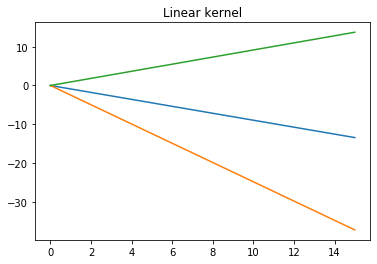

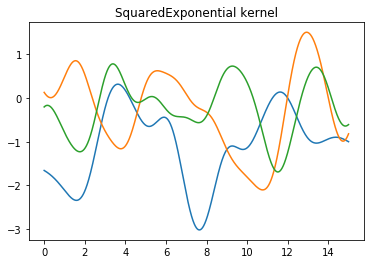

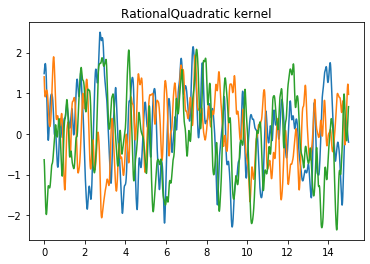

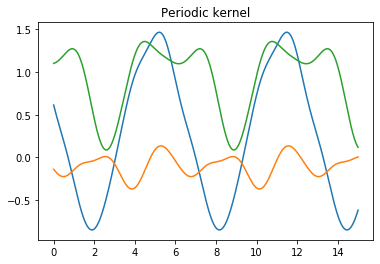

In [5]:
# Plot samples from the prior of each GP
for name, gp in gps.items():
    y_samples = gp.sample_prior(X_test, n_samples=3)
    plt.plot(X_test, y_samples)
    plt.title('{} kernel'.format(name))
    plt.show()

In [6]:
# Define GP
gp = gps['Periodic']

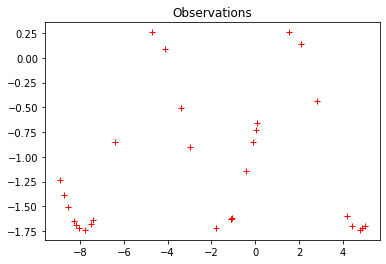

In [7]:
# Generate observations using a sample drawn from the prior.
X_train = np.sort(np.random.uniform(-9, 5, 30))[:, np.newaxis]
y_train = np.sin(X_train) + 2*np.random.randn(60) #gp.sample_prior(X_train)
y_train = y_train[:, 0]  # Only one sample

plt.plot(X_train[:, 0], y_train, 'r+')
plt.title('Observations')
plt.show()

In [8]:
# Generate posterior samples, saving the posterior mean and covariance too.
f_star_samples, f_star_mean, f_star_covar = gp.sample_posterior(X_train, y_train, X_test, n_samples=20)

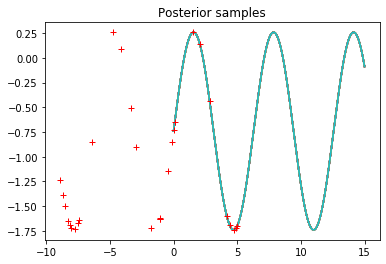

In [9]:
# Plot poterior mean and 95% confidence interval.
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
plt.plot(X_test, f_star_mean, 'b')
plt.fill_between(X_test[:, 0], f_star_mean - error, f_star_mean + error, alpha=0.3)

# Plot samples from posterior
plt.plot(X_test, f_star_samples)

# Also plot our observations for comparison
plt.plot(X_train[:, 0], y_train, 'r+')

plt.title('Posterior samples')
plt.show()

In [10]:
success = gp.optimize(X_train, y_train)
if success:
    print('MAP estimate of theta is {}. Maximised log marginal liklehihood is {}.'.format(gp.kernel.theta_MAP, gp.max_log_marginal_likelihood_value))
else:
    print('Optimization failed. Try setting different initial value of theta.')

MAP estimate of theta is [0.15915494]. Maximised log marginal liklehihood is 159.68104610470843.


In [11]:
# Create coordinates in parameter space at which to evaluate the lml.
frequency = np.linspace(1/(3*np.pi), 1/np.pi, 100)
#length_scales = np.linspace(0.01, 1.4, 100)
noise_variance = np.linspace(1e-12, 1e-2, 100)
#X, Y = np.meshgrid(length_scales, noise_variance)
X, Y = np.meshgrid(frequency, noise_variance)

In [12]:
# Evaluate the lml at these coordinates.
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(X_train, y_train, theta=[x[0]], noise_var=x[1]), list(zip(X.ravel(), Y.ravel())))))
Z = Z.reshape((X.shape))

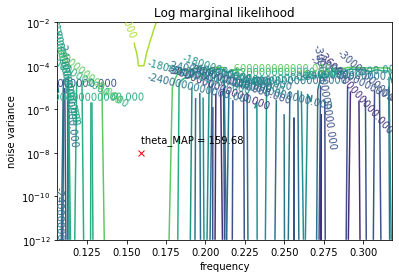

In [13]:
# Plot the contours.
fig, ax = plt.subplots()
ax.set_yscale('log')
levels = np.arange(-3, 3, 0.25)
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.plot(gp.kernel.theta_MAP[0], gp.noise_var, color='red', marker='x')
plt.annotate('theta_MAP = {:.2f}'.format(
    gp.max_log_marginal_likelihood_value), xy=(gp.kernel.theta_MAP[0], gp.noise_var + 2e-8))
plt.title('Log marginal likelihood')
#plt.xlabel('length scale')
plt.xlabel('frequency')
plt.ylabel('noise variance')
plt.show()

In [14]:
f_star_samples, f_star_mean, f_star_covar = gp.sample_posterior(X_train, y_train, X_test, n_samples=20)

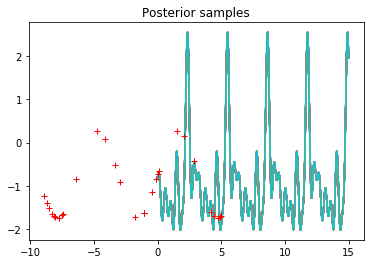

In [15]:
# Plot poterior mean and 95% confidence interval.
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
plt.plot(X_test, f_star_mean, 'b')
plt.fill_between(X_test[:, 0], f_star_mean - error, f_star_mean + error, alpha=0.3)

# Plot samples from posterior
plt.plot(X_test, f_star_samples)

# Also plot our observations for comparison
plt.plot(X_train[:, 0], y_train, 'r+')

plt.title('Posterior samples')
plt.show()

# scikit

In [47]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, ExpSineSquared, RationalQuadratic

In [17]:
kernel1 = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)# + WhiteKernel(noise_level=1)

In [18]:
GPR = gaussian_process.GaussianProcessRegressor(kernel=kernel1)
GPR.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [19]:
kernel1

1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1)

In [20]:
GPR.kernel_

0.581**2 + Matern(length_scale=3.83, nu=1.5) + WhiteKernel(noise_level=1e-05)

In [21]:
#X_pred = np.linspace(0, X.shape[0]+100).reshape(-1,1)
y_pred, sigma = GPR.predict(X_test, return_std=True)
error = (1.96 * sigma).reshape(-1,1)

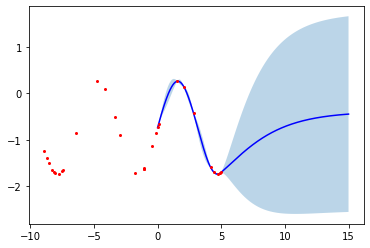

In [22]:
plt.plot(X_test.ravel(), y_pred.ravel(), 'b')
plt.fill_between(X_test.ravel(), y_pred.ravel() - error.ravel(), y_pred.ravel() + error.ravel(), alpha=0.3)

plt.plot(X_train, y_train, 'ro', ms=2)

In [23]:
kernel2 = ConstantKernel() + ExpSineSquared(length_scale=1, periodicity=2*np.pi) + WhiteKernel(noise_level=1)# + WhiteKernel(noise_level=1)

In [24]:
GPR = gaussian_process.GaussianProcessRegressor(kernel=kernel2)
GPR.fit(X_train, y_train)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 + ExpSineSquared(length_scale=1, periodicity=6.28) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [25]:
kernel2


1**2 + ExpSineSquared(length_scale=1, periodicity=6.28) + WhiteKernel(noise_level=1)

In [26]:
GPR.kernel_

0.965**2 + ExpSineSquared(length_scale=1.29, periodicity=12.6) + WhiteKernel(noise_level=1e-05)

In [27]:
#X_pred = np.linspace(0, X.shape[0]+100).reshape(-1,1)
y_pred, sigma = GPR.predict(X_test, return_std=True)
error = (1.96 * sigma).reshape(-1,1)

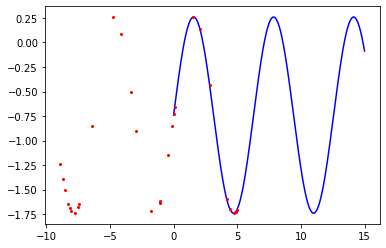

In [28]:
plt.plot(X_test.ravel(), y_pred.ravel(), 'b')
plt.fill_between(X_test.ravel(), y_pred.ravel() - error.ravel(), y_pred.ravel() + error.ravel(), alpha=0.3)

plt.plot(X_train, y_train, 'ro', ms=2)

# PyMC3

In [ ]:
import pymc3 as pm
import theano.tensor as tt

In [ ]:
with pm.Model() as gp_fit:
    rho = pm.Gamma('ρ', 1, 1)
    eta = pm.Gamma('η', 1, 1)
    K = eta * pm.gp.cov.Matern32(1, rho)

In [ ]:
with gp_fit:
    M = pm.gp.mean.Zero()
    sigma = pm.HalfCauchy('σ', 2.5)

In [ ]:
with gp_fit:
    y_obs = pm.gp.Latent('y_obs', mean_func=M, cov_func=K, sigma=sigma, observed={'X':X, 'Y':Y})

In [ ]:
help(pm.gp.GaussianProcess)

In [ ]:

    trace = pm.sample(2000, n_init=20000)

In [ ]:
Z = np.linspace(-6, 6, 100).reshape(-1, 1)
with gp_fit:
    gp_samples = pm.gp.sample_gp(trace[1000:], y_obs, Z, samples=50)

In [ ]:
Y

In [ ]:
basic_model = pm.Model()
with basic_model:
    P = pm.Gamma('P', alpha=2*np.pi*0.1, beta=0.1)
    L = pm.Gamma('L', alpha=3.0*0.1, beta=0.1)
    sigma = pm.Normal('sigma', 0,5)
    
    mean_func = pm.gp.mean.Constant(c=0)
    cov_func = pm.gp.cov.Periodic(input_dim=1, ls=L, period=P)
    
    gp = pm.gp.Latent(mean_func, cov_func)


In [ ]:
help(pm.sample)

In [ ]:
with basic_model:
    trace = pm.sample(10000, n_init=20000, chains=4 )

In [ ]:
from pymc3 import traceplot
traceplot(trace[500:], varnames=['sigma', 'P', 'L']);


In [ ]:
np.mean(trace.P)

In [ ]:
np.mean(trace.L)

In [ ]:
np.mean(trace.sigma)

In [ ]:
f = gp.prior("f", X)

In [ ]:
f_star = gp.conditional("f_star", X_star)

# AirPassenger

In [ ]:
def mape(y_true, y_pred):
    return np.mean(abs((y_pred-y_true)/y_true))

In [ ]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, ExpSineSquared, RationalQuadratic

In [138]:
# AirPassengers
y=np.array([112, 118, 132, 129, 121,135, 148, 148, 136, 119, 104, 118,
 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
 145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
 171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
 196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
 204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
 242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
 284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
 315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
 340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
 360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432]).reshape((-1,1))
y=np.log(y)
X=np.arange(y.shape[0]).reshape((-1,1))

h=36

y_train = y[:-h]
y_test = y[-h:]
X_train = X[:-h]
X_test = X[-h:]


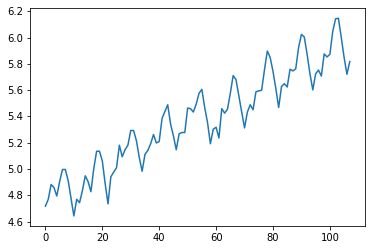

In [139]:
plt.plot(X_train,y_train)

In [140]:
k1 = ConstantKernel() 

In [141]:
k2 = RBF(length_scale=60)*ExpSineSquared(length_scale=1, periodicity=12)

In [142]:
k3 = RBF(length_scale=90)*ExpSineSquared(length_scale=1, periodicity=12)

In [143]:
k4 =  WhiteKernel(noise_level=1)

In [144]:
kernel_gp = k1 + k2 + k3 + k4

In [145]:
GPR = gaussian_process.GaussianProcessRegressor(kernel=kernel_gp)
GPR.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 + RBF(length_scale=60) * ExpSineSquared(length_scale=1, periodicity=12) + RBF(length_scale=90) * ExpSineSquared(length_scale=1, periodicity=12) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [146]:
GPR.kernel_

4.99**2 + RBF(length_scale=199) * ExpSineSquared(length_scale=1e+05, periodicity=7.52) + RBF(length_scale=1.06e+03) * ExpSineSquared(length_scale=1.18, periodicity=12) + WhiteKernel(noise_level=0.0017)

In [147]:
#X_test = np.arange(y.shape[0], y.shape[0]+24).reshape(-1,1)
y_pred, sigma = GPR.predict(X_test, return_std=True)
error = (1.96 * sigma).reshape(-1,1)

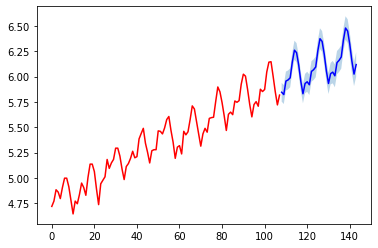

In [153]:
plt.plot(X_test.ravel(), y_pred.ravel(), 'b' )
plt.fill_between(X_test.ravel(), y_pred.ravel() - error.ravel(), y_pred.ravel() + error.ravel(), alpha=0.3)

plt.plot(X_train, y_train, 'r-', ms=2)

In [137]:
mape(np.exp(y_pred), np.exp(y_test))

0.055514842272249065

# Wikipedia 

In [175]:
# f = plt.figure(figsize=(19, 15))
# plt.matshow(df.corr(), fignum=f.number)
# plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
# plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);
# plt.matshow(f_star_covar)



In [178]:
input_file="rw_log_views.csv"
df=pd.read_csv(input_file, sep=";",decimal=",")

df['date']=df['date'].astype('datetime64[ns]') 
df=df.set_index("date", drop=True)

y = df.iloc[df.index>"2012", 0].ravel().reshape(-1,1)
X = np.arange(y.shape[0]).reshape(-1,1)

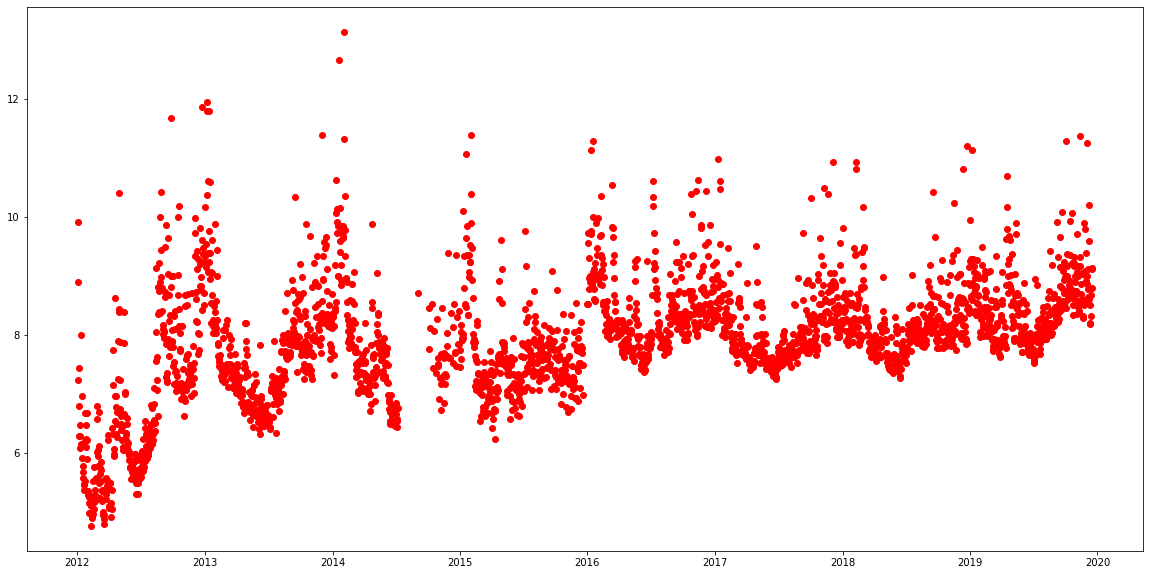

In [179]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(df.iloc[df.index>"2012"], 'ro')

### scikit

In [180]:
k1 = ConstantKernel() 

In [181]:
k2 = RBF(length_scale=60)*ExpSineSquared(length_scale=1, periodicity=7)

In [182]:
k3 = RBF(length_scale=365)*ExpSineSquared(length_scale=1, periodicity=365)

In [183]:
k4 =  WhiteKernel(noise_level=4)

In [184]:
kernel_gp = k1 + k2 + k3 + k4

In [185]:
GPR = gaussian_process.GaussianProcessRegressor(kernel=kernel_gp)
GPR.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 + RBF(length_scale=60) * ExpSineSquared(length_scale=1, periodicity=7) + RBF(length_scale=365) * ExpSineSquared(length_scale=1, periodicity=365) + WhiteKernel(noise_level=4),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [186]:
GPR.kernel_

7.91**2 + RBF(length_scale=42.9) * ExpSineSquared(length_scale=29.9, periodicity=3.18) + RBF(length_scale=256) * ExpSineSquared(length_scale=0.0508, periodicity=307) + WhiteKernel(noise_level=0.134)

In [187]:
#X_test = np.arange(y.shape[0], y.shape[0]+24).reshape(-1,1)
y_pred, sigma = GPR.predict(X, return_std=True)
error = (1.96 * sigma).reshape(-1,1)

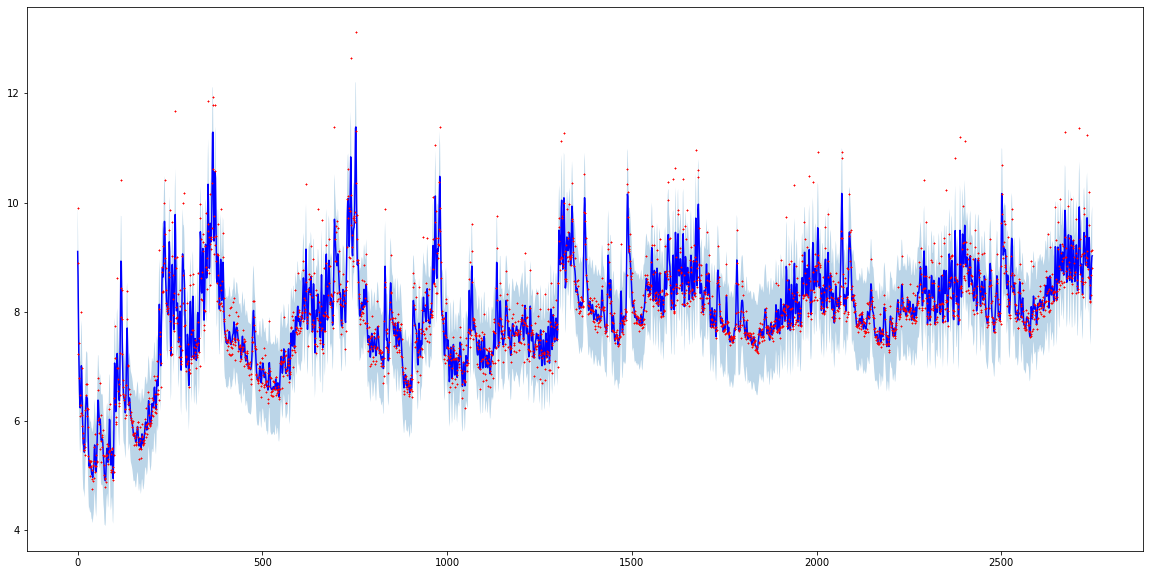

In [188]:
plt.plot(X.ravel(), y_pred.ravel(), 'b' )
plt.fill_between(X.ravel(), y_pred.ravel() - error.ravel(), y_pred.ravel() + error.ravel(), alpha=0.3)

plt.plot(X, y, 'r+', ms=2)

### PyMC3

In [ ]:
import pymc3 as pm
import theano.tensor as tt

In [ ]:
basic_model = pm.Model()
with basic_model:
    P = pm.Gamma('P', alpha=2*np.pi*0.1, beta=0.1)
    L = pm.Gamma('L', alpha=3.0*0.1, beta=0.1)
    sigma = pm.Normal('sigma', 0,5)
    
    mean_func = pm.gp.mean.Constant(c=0)
    cov_func = pm.gp.cov.Periodic(input_dim=1, ls=L, period=P)
    
    gp = pm.gp.Latent(mean_func, cov_func)


In [ ]:
with basic_model:
    trace = pm.sample(10000, n_init=20000, chains=4 )

In [ ]:
from pymc3 import traceplot
traceplot(trace[500:], varnames=['sigma', 'P', 'L']);


In [ ]:
np.mean(trace.P)

In [ ]:
np.mean(trace.L)

In [ ]:
np.mean(trace.sigma)

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()